## Learning Representations of Gene Ontology: Embedding Term Descriptors using Large Language Models (LLMs)

The Gene Ontology (GO) is a directed knowledge graph where **each node is a GO term** defining a particular aspect of genes and their products. The GO terms (nodes) are categoryzed into three major ontologies:

- <font color="grey">***Molecular Function (MF)***</font>: specify the **activity** performed by the gene product, which can be "catalysis", "transport", etc. These functions can be narrowed down by more specific GO terms. "protein kinase activity" is more specific than just "catalysis"


- <font color="grey">***Cellular Component (CC)***</font>: specify the subcellular **location** of the gene product, which includes compartments (e.g. 'chloroplast', 'nucleus') or macromolecular complexes such as the 'proteasome' or 'ribosome'.


- <font color="grey">***Biological Process (BP)***</font>: specify the biological **pathway** in which the gene product is involved. Examples are 'DNA repair', 'carbohydrate metabolic process', or more general processes such as 'byosynthetic process'.

Actually, the GO graph is an amalgamation of these three aspects of gene annotation. The terms are organized **hierarchically** and **interconnected by edges representing their relationships**. Thus, the GO graph can be seen that as three independent trees (MF, CC and BP). As a directed graph, we define *parent* and *child* terms according to the *generations* they belong in the tree: terms closer to the root are parents and those closer to the terminal leaves are child terms.

We can use the GO graph to classify genes and proteins regarding their functions, processes in which they are involved and the subcellular location. The GO graph is an essential tool to predict functions of newly discovered genes.

In this notebook, we will extract features from GO term definitions to be used im machine learning applications. First, we will obtain the Term Frequency - Inverse Document Frequency (TF-IDF) of the **corpus** and use as features to train classification models.

>Corpus: collection of texts (here, each GO term definition is a *document*)

In another approach, we will **embed the text definition** into a **feature vector** using pretrained **Natural Language Processing (NLP) Large Language Models (LLMs)**. Such models were trained in a vast number of texts from different sources, and have the ability to extract meaningful dependencies between terms in a sentence.

>**Text Embeddings**: Machine learning algorithms are quite narrow about their 'understanding': they accept **only numbers**. Any other type of data have to be converted into numbers to be fed into any data-crunching pipeline. To use texts as input into machine learning models, they have to be embedded using techniques that extract meaningful hidden features in the text considering the sequential appearance of words. The order of words is essential to ensure that the essential meaning of the text is include in the feature vector, i.e., the **text embeddings**  

**Natural Language Processing** (**NLP**) is a hot field of machine learning and involves tecniques to extract meaninful contextualized information from sequences of words. There is a variety of applications that includes **sentiment analysis** and **text generation** for product reviews and chatGPT, respectivelly.

We will use all these extracted features to do some predictions:

- predict new edges in gene ontology graph (new insights in pathways)
- quantify the relative frequency of GO terms (without necessarilly naming it) based on article sentences (paperGOindex): Break article into sentences and process one or more sentences in a sequence.


In [ ]:
# install required libraries

# !pip install obonet
# !pip install nltk
# !pip install transformers
# !pip install datasets
# !pip install wordcloud

In [10]:
# import libraries

import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from obonet import read_obo
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from yellowbrick.text import FreqDistVisualizer
from wordcloud import WordCloud
from tqdm.notebook import tqdm_notebook

# progress bar for loops
tqdm_notebook.pandas()

# set home directory
from pathlib import Path

home_dir = Path("../GO-graph-embed/")
print(f"Home directory: {home_dir.as_posix()}")

# download / update punkt, the nltk's recommended sentences' tokenizer
import nltk

nltk.download("punkt")

# custom functions

# plot confusion matrix
def plot_cm(y_true: pd.Series, y_pred: pd.Series):
    # print out the balanced accuracy score
    print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_pred, y_true):.1%}")

    cm = confusion_matrix(
        y_true,
        y_pred,
        normalize="pred",
    )

    # converting into dataframe for easy plotting
    cm_df = pd.DataFrame(
        cm,
        index=["Biological Process", "Cellular Component", "Molecular Function"],
        columns=["Biological Process", "Cellular Component", "Molecular Function"],
    )

    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1.2)
    sns.heatmap(
        data=cm_df,
        annot=True,
        cmap="Blues",
    )
    plt.title("Confusion Matrix")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

Home directory: ../GO-graph-embed


[nltk_data] Downloading package punkt to /home/clever/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Reading and Parsing GO Graph Data

The GO graph is stored in the *OBO format*, which is specifically tailored for constructing and representing biological ontologies. To read and parse the GO graph, we utilize the Python library *obonet*, which allows us to convert it into a NetworkX object. This object provides a comprehensive toolkit for graph manipulation and analysis.

First things first, let's load the GO graph file and check some attributes:

In [2]:
go_graph = read_obo(home_dir.joinpath("data/go-basic.obo"))

print(f"The GO graph is a {go_graph}.")
print(f"Is Directed Acyclic Graph (DAG)?: {nx.is_directed_acyclic_graph(go_graph)}")
print(f"Is MultiGraph (multiple edges between two nodes)?: {go_graph.is_multigraph()}")
print(f"Is weighted graph?: {nx.is_weighted(go_graph)}")

The GO graph is a MultiDiGraph named 'go' with 43248 nodes and 84805 edges.
Is Directed Acyclic Graph (DAG)?: True
Is MultiGraph (multiple edges between two nodes)?: True
Is weighted graph?: False


The nodes of the GO graph contain attributes with essential information about each term. To get a glimpse of this data, let's print out the attributes of a randomly selected node:

In [3]:
go_graph.nodes()[random.choice([x for x in go_graph.nodes()])]

{'name': 'pentachlorophenol monooxygenase activity',
 'namespace': 'molecular_function',
 'def': '"Catalysis of the reaction: pentachlorophenol + NADPH + H+ + O2 = tetrachlorohydroquinone + NADP+ + chloride." [EC:1.14.13.50]',
 'synonym': ['"PCB 4-monooxygenase activity" RELATED [EC:1.14.13.50]',
  '"PCB4MO activity" RELATED [EC:1.14.13.50]',
  '"PCP hydroxylase activity" RELATED [EC:1.14.13.50]',
  '"PcpB" RELATED [EC:1.14.13.50]',
  '"pentachlorophenol 4-monooxygenase activity" EXACT []',
  '"pentachlorophenol dechlorinase activity" RELATED [EC:1.14.13.50]',
  '"pentachlorophenol dehalogenase activity" RELATED [EC:1.14.13.50]',
  '"pentachlorophenol hydroxylase activity" EXACT []',
  '"pentachlorophenol,NADPH:oxygen oxidoreductase (hydroxylating, dechlorinating)" RELATED [EC:1.14.13.50]'],
 'xref': ['EC:1.14.13.50',
  'MetaCyc:PCP4MONO-RXN',
  'RHEA:18685',
  'UM-BBD_enzymeID:e0148'],
 'is_a': ['GO:0016709']}

All GO terms contain the following essential attributes:

>***name***: unique identifier of the term in a human-readable format

>***namespace***: one of the three major ontologies (MF, CC or BP) to which the term belongs

>***definition***: short description of what the GO term means for humans. It can also contains references to publications defining the term (e.g. PMID:10873824).

There are additional attributes of each node corresponding to GO terms, but we won't be using them in this project.

### Converting the GO terms attributes into a Pandas Dataframe

We will extract the attributes from GO graph nodes into a dataframe to facilitate the processing of the text definitions. We will also add a column with the length of the text definition of each GO term. This will help us to determine the parameters when deploying **pre-trained Large Language Models (LLMs)** to extract features from GO terms' definitions and embed them into a feature vector.

In [ ]:
# create GO definitions dataframe

# empty dataframe
go_df = pd.DataFrame(columns=["go_id", "name", "aspect", "definition", "def_length"])

for idx, item in tqdm_notebook(
    enumerate(go_graph.nodes.items()), total=len(go_graph.nodes)
):
    go_term = item[0]
    name = item[1]["name"]
    aspect = item[1]["namespace"]
    definition = item[1]["def"].split(sep='"', maxsplit=2)[1]
    length = len(definition)
    go_df.loc[idx] = [
        go_term,
        name,
        aspect,
        definition,
        length,
    ]

# saving dataframe
home_dir.joinpath("data/").mkdir(parents=True, exist_ok=True)
go_df.to_csv(home_dir.joinpath("data/go_df.csv"), index=False)

go_df

We can use the Pandas' method `Dataframe.describe()` to check the mean, max and min lengths of GO terms' definitions (the method considers only *numeric* columns...):

In [4]:
go_df = pd.read_csv(home_dir.joinpath("data/go_df.csv"))

print(f"GO entries: {go_df.shape[0]}, features: {go_df.shape[1]}")
display(go_df.head())

GO entries: 43248, features: 5


,go_id,name,aspect,definition,def_length
0,GO:0000001,mitochondrion inheritance,biological_process,"The distribution of mitochondria, including th...",183
1,GO:0000002,mitochondrial genome maintenance,biological_process,The maintenance of the structure and integrity...,145
2,GO:0000003,reproduction,biological_process,The production of new individuals that contain...,124
3,GO:0000006,high-affinity zinc transmembrane transporter a...,molecular_function,Enables the transfer of zinc ions (Zn2+) from ...,248
4,GO:0000007,low-affinity zinc ion transmembrane transporte...,molecular_function,Enables the transfer of a solute or solutes fr...,285


We can also visually inspect the length (the **number of characters** in this case...) distribution of GO terms text definitions. The [`seaborn.histplot()`](https://seaborn.pydata.org/generated/seaborn.histplot.html) function can plot the *kernel density distribution* (*KDE*) to estimate the text length distribution:

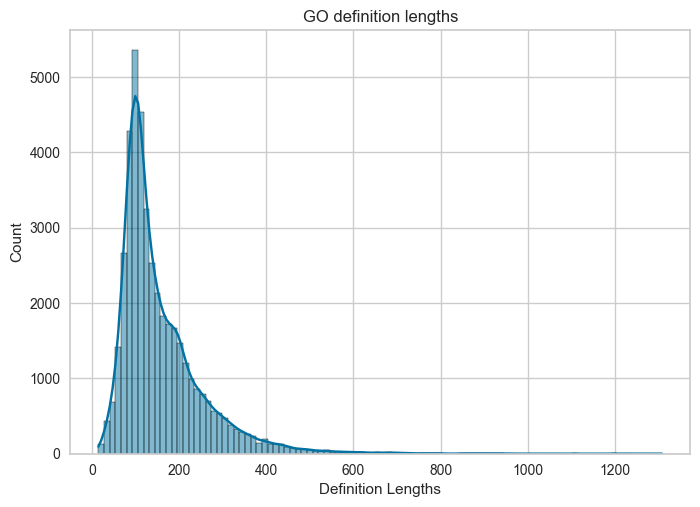

In [5]:
go_hist = sns.histplot(go_df["def_length"].values, bins=100, kde=True)
go_hist.set_title("GO definition lengths")
go_hist.set_xlabel("Definition Lengths")

plt.show()

By plotting the length of the GO terms definitions and analyzing the quartiles, we can see that most definitions fall bellow 200 words (75%), with mean length of ~150 words.

## Using LLM Transformer to Predict GO Major Ontologies (BP, MF, CC)

[**Transformers**](https://huggingface.co/docs/transformers/index) for text classification is a 'hot' topic in machine learning and behind hipped generative models like [chatGPT](https://chat.openai.com). Text transformer architectures are designed to find dependencies between words in a sentence regarding their positions and use these dependencies for text ranking or classification, in addition to generative models capable of generate new sentences based on a query.

We will **fine-tune** (i.e. train the model to perform a **specific task**) the pretrained **Large Language Model** (LLM) [bert-base-multilingual-cased](https://huggingface.co/bert-base-multilingual-cased) to classify GO term definitions regarding the major GO ontologies (BP, CC and MF) to which each one belong. We will also obtain text embeddings of GO term definitions to use them as additional data to train models to predict protein annotations.

The model is the  based on the [Bidirectional Encoder Representations from Transformers (BERT)](https://huggingface.co/docs/transformers/model_doc/bert) architecture pre-trained with millions of [Wikipedia](https://www.wikipedia.org/) entries in 104 languages.

We need to preprocess the dataset in such a way that the pre-trained model can understand. First we'll create train, validation and test datasets with the input text from GO terms' definitions. Then, the datasets will be **'tokenized'**, i.e., the input texts will be splitted into tokens using a set of rules and delimited by special tokens that says to the model where the sequence and sentences start and end.

 The datasets are created using the Hugging Face's library [Dataset](https://huggingface.co/docs/datasets/index). Actually, later we will be using pre-trained sequence classification models and respective tokenizers from [Hugging Face](https://huggingface.co/).

First, we have to make some changes in the original GO dataframe to feed the data into the model:

In [44]:
# rename definition column
go_df.rename(columns={"definition": "text"}, inplace=True)

# converting categorical labels to numbers (aspect)
go_df["aspect"] = pd.Categorical(go_df["aspect"])

# getting categorical codes
go_df["label"] = go_df["aspect"].cat.codes

go_df

,go_id,name,aspect,text,def_length,label
0,GO:0000001,mitochondrion inheritance,biological_process,"The distribution of mitochondria, including th...",183,0
1,GO:0000002,mitochondrial genome maintenance,biological_process,The maintenance of the structure and integrity...,145,0
2,GO:0000003,reproduction,biological_process,The production of new individuals that contain...,124,0
3,GO:0000006,high-affinity zinc transmembrane transporter a...,molecular_function,Enables the transfer of zinc ions (Zn2+) from ...,248,2
4,GO:0000007,low-affinity zinc ion transmembrane transporte...,molecular_function,Enables the transfer of a solute or solutes fr...,285,2
...,...,...,...,...,...,...
43243,GO:2001313,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,biological_process,The chemical reactions and pathways involving ...,95,0
43244,GO:2001314,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,biological_process,The chemical reactions and pathways resulting ...,115,0
43245,GO:2001315,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,biological_process,The chemical reactions and pathways resulting ...,115,0
43246,GO:2001316,kojic acid metabolic process,biological_process,The chemical reactions and pathways involving ...,57,0


We can iterate over the aspect categories we just created to check the correspondence between the classes and the label numbers:

In [45]:
for code, aspect in enumerate(go_df.aspect.cat.categories):
    print(f"{code}: {aspect}")

0: biological_process
1: cellular_component
2: molecular_function


Selecting only the columns we need for model's fine-tunning:

In [46]:
data = go_df[["text", "label"]].copy()
data

,text,label
0,"The distribution of mitochondria, including th...",0
1,The maintenance of the structure and integrity...,0
2,The production of new individuals that contain...,0
3,Enables the transfer of zinc ions (Zn2+) from ...,2
4,Enables the transfer of a solute or solutes fr...,2
...,...,...
43243,The chemical reactions and pathways involving ...,0
43244,The chemical reactions and pathways resulting ...,0
43245,The chemical reactions and pathways resulting ...,0
43246,The chemical reactions and pathways involving ...,0


We can visualize the most frequent terms in the data by plotting a *word cloud*, which is a nice way to grasp the most frequent words:

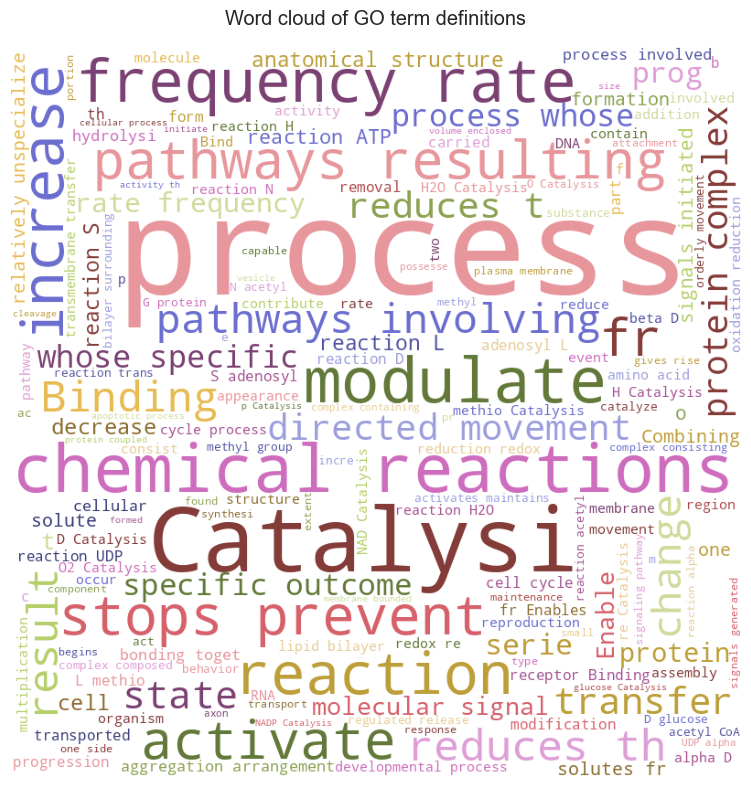

In [47]:
go_wordcloud = WordCloud(
    width=800, height=800, background_color="white", min_font_size=10, colormap="tab20b",
).generate(data.text.to_string())

plt.figure(figsize=(8, 8), facecolor=None)
plt.suptitle("Word cloud of GO term definitions")
plt.imshow(go_wordcloud)
plt.axis("off")
plt.tight_layout(pad=1)
plt.show()

The number of characters of each definition is showed in the *def_length* column. The language model that we'll fine-tune and use for predictions accepts a limited number of tokens as input In our case study, the **bert-base-multilingual-cased** accepts **512 tokens** (actually 500 tokens and two special tokens [CLS] and [SEP] that we will get to know later).

A box-plot can provide useful insight on the lengths to choose the better hyperparameters for tokenization and training. Here, we use the **re** module to find all the words in each definition and return the length using a **lambda** function applied to the *definition* column:

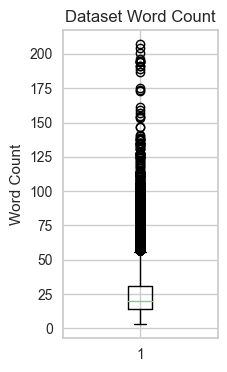

In [48]:
plt.figure(figsize=(2, 4))
plt.title("Dataset Word Count")

plt.boxplot(data.text.apply(lambda x: len(re.findall(r"\w+", x))))
plt.ylabel("Word Count")

plt.show()

All GO terms' definitions fit the input size required for fine-tuning (510 tokens) but we may want to limit the length of inputs to speed-up the fine-tuning process. Let's proceed to create the dataset with train and test sets using Hugging Face's Dataset `train_test_split()` method. We use stratification to preserve labels ratios between datasets:

In [55]:
from datasets import Dataset

# create dataset
dataset = Dataset.from_pandas(data)

# change label column to ClassLabe to allow stratification
dataset = dataset.class_encode_column("label")

dataset = dataset.train_test_split(test_size=0.3, stratify_by_column="label")
dataset

Stringifying the column:   0%|          | 0/43248 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/43248 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 30273
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12975
    })
})

The **Tokenization strategy must match the model of choice**. This is key to ensure that tokens will be mapped to the **same indices** presented to the model during the training phase and also use the **same special tokens** to delimit the beggining of a text sequence and the separation between sentences.

Here, we use [BertTokenizerFast](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertTokenizerFast) using the tokenization strategy of the pre-trained model (bert-base-multilingual-uncased) to get rid of uppercase and capital letters. With lowercase inputs, the number of tokens is usually smaller and generalizes better for unseen text sequences inputs in **production phase**. Moreover, we can change it later and see if the model performs better or not with cased inputs.


In [56]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("bert-base-multilingual-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, max_length=150, truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

tokenized_dataset

Map:   0%|          | 0/30273 [00:00<?, ? examples/s]

Map:   0%|          | 0/12975 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 30273
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 12975
    })
})

Let's take a look on the first sample from the training dataset:

Explaining the keys in train_ds sample items:

- **input_ids**: indices of each token in the sequence (these indices were generated during model pre-training)
- **token_type_ids**:  references of the sentence to which the token belongs
- **attention_mask**: indicates if the token should be attended or not

We can decode the the **input_ids** to obtain the original text. Below we print out the decoded definitions based on the input_ids (I did some changes in the print for better visualization of the decoded input ids and the input ids):

In [57]:
dataset_len = len(tokenized_dataset["train"]["input_ids"])

for i in range(5):
    idx = random.randint(0, dataset_len)
    print(tokenizer.decode(tokenized_dataset["train"]["input_ids"][idx]))
    input_ids_list = tokenized_dataset["train"]["input_ids"][idx]
    print(input_ids_list)
    print(f"Input length: {len(input_ids_list)}")
    print(50 * "=")

[CLS] the chemical reactions and pathways resulting in the breakdown of naphtho - gamma - pyrone. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[101, 10103, 18454, 43690, 10110, 88475, 26822, 10104, 10103, 79222, 10108, 37883, 13509, 10819, 118, 26499, 118, 158, 19755, 12

In the output above we can see the sentences delimited by the special tokens **Classification Token [CLS]** and **Separator Token [SEP]**. [CLS] delimits the start of the sequence for the BERT model we will be using. 

and set the model to generate embeddings for sequence classification tasks. [SEP] is used to separate sentences in sentence-pair tasks and help the model to capture the relationships between the two senteces concatenated by the [SEP]. The **padding to ensure same-sized sentences** during tokenization is represented by the special padding token **[PAD]**.

>**Truncation and Padding**: truncation and padding parameters tell to the tokenizer how to handle sequences of variable length. Input sequences with more tokens than the number accepted by the model will be truncated if *truncation* parameter is 'True'. On the other hand, if the sequences are shorter than the model's accept, the special padding token [PAD] will be added until the number of tokens in the input match the model's requireiments. *Truncation* and *padding* are key to ensure that the input will be the same size. This is key because the input of the model are fixed-size tensors set during model training (510 + 2 special tokens [CLS] and [SEP] = 512).

Now, let's instantiate the model class [BertForSequenceClassification](https://huggingface.co/docs/transformers/v4.33.2/en/model_doc/bert#transformers.BertForSequenceClassification) loaded with the **weights** from the pre-trained model "bert-base-multilingual-cased" and define the number of target labels we want to predicted. In our case-study, we will predict if the text talks about Biological Process, Cellular Component or Molecular Function. Thus, the number of labels is **3**.

In [58]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-uncased", num_labels=3)

model.cuda()
model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

We will fine-tune the model using the [Trainer](https://huggingface.co/docs/transformers/v4.33.2/en/main_classes/trainer#transformers.Trainer) class optimized to train Hugging Face's models.

We need to configure the **trainer's hyperparameters** using the [TrainingArguments](https://huggingface.co/docs/transformers/v4.33.2/en/main_classes/trainer#transformers.TrainingArguments) and set the evaluation metrics using the [evaluate](https://huggingface.co/docs/evaluate/index) module to monitor the training process and evaluate the performance after fine-tuning.

>To see the full list of tunable training hyperparameters and available metrics, click the links above. Alternativelly, you can make some elegant code to show them.

In [59]:
# PyTorch Trainer
from transformers import TrainingArguments
import accelerate

train_args = TrainingArguments(output_dir="test_trainer")

# list training parameters
args_list = [
    x for x in list(dir(train_args)) if not re.compile(r"\b_[A-Za-z0-9_]*\b").match(x)
]
print(f"There are {len(args_list)} training arguments: {args_list}")

There are 140 training arguments: ['adafactor', 'adam_beta1', 'adam_beta2', 'adam_epsilon', 'auto_find_batch_size', 'bf16', 'bf16_full_eval', 'data_seed', 'dataloader_drop_last', 'dataloader_num_workers', 'dataloader_pin_memory', 'ddp_backend', 'ddp_broadcast_buffers', 'ddp_bucket_cap_mb', 'ddp_find_unused_parameters', 'ddp_timeout', 'ddp_timeout_delta', 'debug', 'deepspeed', 'deepspeed_plugin', 'default_optim', 'device', 'disable_tqdm', 'distributed_state', 'do_eval', 'do_predict', 'do_train', 'eval_accumulation_steps', 'eval_batch_size', 'eval_delay', 'eval_steps', 'evaluation_strategy', 'fp16', 'fp16_backend', 'fp16_full_eval', 'fp16_opt_level', 'framework', 'fsdp', 'fsdp_config', 'fsdp_min_num_params', 'fsdp_transformer_layer_cls_to_wrap', 'full_determinism', 'get_process_log_level', 'get_warmup_steps', 'gradient_accumulation_steps', 'gradient_checkpointing', 'greater_is_better', 'group_by_length', 'half_precision_backend', 'hub_model_id', 'hub_private_repo', 'hub_strategy', 'hub_t

Since the Trainer does not have an automatic evaluator of model's performance during training, we have to add metrics using *evaluate* and pass it to Trainer through TrainingArguments.

We can use ROC/AUC score to assess model's performance. Additionally, we need to define a function to convert the predictions to logits to pass it to the *compute* method as explained by [this tutorial](https://huggingface.co/docs/transformers/training) in Hugging Face:

In [60]:
import evaluate

# list metrics
metrics_list = evaluate.list_evaluation_modules()
print(f"There are {len(metrics_list)} available metrics: {metrics_list}")

# load roc_auc metric
metric = evaluate.load("accuracy")


# convert preds --> logits
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


# set evaluation for training
train_args = TrainingArguments(
    output_dir="test_trainer",
    evaluation_strategy="epoch",
)

There are 140 available metrics: ['precision', 'code_eval', 'roc_auc', 'cuad', 'xnli', 'rouge', 'pearsonr', 'mse', 'super_glue', 'comet', 'cer', 'sacrebleu', 'mahalanobis', 'wer', 'competition_math', 'f1', 'recall', 'coval', 'mauve', 'xtreme_s', 'bleurt', 'ter', 'accuracy', 'exact_match', 'indic_glue', 'spearmanr', 'mae', 'squad', 'chrf', 'glue', 'perplexity', 'mean_iou', 'squad_v2', 'meteor', 'bleu', 'wiki_split', 'sari', 'frugalscore', 'google_bleu', 'bertscore', 'matthews_correlation', 'seqeval', 'trec_eval', 'rl_reliability', 'angelina-wang/directional_bias_amplification', 'cpllab/syntaxgym', 'kaggle/ai4code', 'codeparrot/apps_metric', 'mfumanelli/geometric_mean', 'poseval', 'brier_score', 'abidlabs/mean_iou', 'abidlabs/mean_iou2', 'giulio98/codebleu', 'mase', 'mape', 'smape', 'dvitel/codebleu', 'NCSOFT/harim_plus', 'JP-SystemsX/nDCG', 'Drunper/metrica_tesi', 'jpxkqx/peak_signal_to_noise_ratio', 'jpxkqx/signal_to_reconstruction_error', 'hpi-dhc/FairEval', 'nist_mt', 'lvwerra/accura

In [33]:
small_train_dataset = tokenized_dataset["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_dataset["test"].shuffle(seed=42).select(range(1000))

print(small_train_dataset)
print(small_eval_dataset)

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})
Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})


In [34]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

/home/clever/anaconda3/envs/torchgpu/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/375 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.07128437608480453, 'eval_accuracy': 0.986, 'eval_runtime': 7.7452, 'eval_samples_per_second': 129.112, 'eval_steps_per_second': 16.139, 'epoch': 1.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.06781265139579773, 'eval_accuracy': 0.988, 'eval_runtime': 7.8792, 'eval_samples_per_second': 126.917, 'eval_steps_per_second': 15.865, 'epoch': 2.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.07205658406019211, 'eval_accuracy': 0.989, 'eval_runtime': 9.7953, 'eval_samples_per_second': 102.089, 'eval_steps_per_second': 12.761, 'epoch': 3.0}
{'train_runtime': 113.3789, 'train_samples_per_second': 26.46, 'train_steps_per_second': 3.307, 'train_loss': 0.10366770426432291, 'epoch': 3.0}


TrainOutput(global_step=375, training_loss=0.10366770426432291, metrics={'train_runtime': 113.3789, 'train_samples_per_second': 26.46, 'train_steps_per_second': 3.307, 'train_loss': 0.10366770426432291, 'epoch': 3.0})